In [1]:
import json
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import datetime


motion_management_result_path = '/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/MotionManagement'
patient_data_root = r'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/PATIENT_DATA'
patient_data_archive_root = f'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Patient_Data_Archive'
logfile_path = '/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles'
logfile_path_archive = f'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles_archive'


# Plan &rarr; Verification displacements from 3D images
Read registration results that was previously made for Plan to Verification 3D images

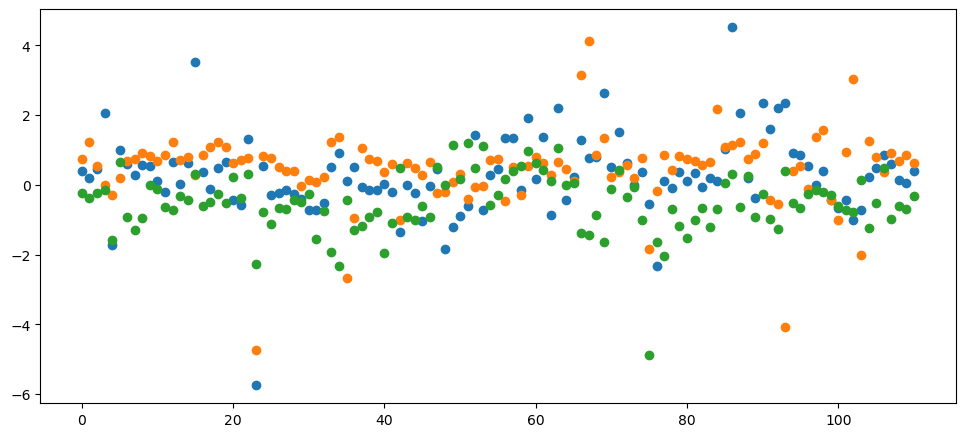

In [2]:
result_filename = '/mnt/P/TERAPI/FYSIKER/David_Tilly/DosePrediction/PatientData/motion_analysis/verification_vs_planning/result.txt'
plan_ver_data = np.loadtxt(result_filename)
num_regs = len(plan_ver_data)

plan_ver_displacements = []


for row in plan_ver_data:
    patient = int(row[0])
    fraction = int(row[1])
    delta_pos = np.array(row[2:5])
    plan_ver_displacements.append(delta_pos)
plan_ver_displacements = np.array(plan_ver_displacements)

f, ax = plt.subplots(figsize=(30/2.54, 13/2.54), sharex=True)
ax.scatter(range(len(plan_ver_displacements)), plan_ver_displacements[:,0], label='X Displacement')
ax.scatter(range(len(plan_ver_displacements)), plan_ver_displacements[:,1], label='Y Displacement')
ax.scatter(range(len(plan_ver_displacements)), plan_ver_displacements[:,2], label='Z Displacement')




In [3]:
def read_report(filename):
    with open(filename, 'r') as file:
        report = json.load(file)
    return report

def find_start_index(cine_times, treatment_time):
    """
    Find the index in cine_times where the treatment time starts.
    if cine times are longer than treatment times, assume that the treatment is during the end of the cines.
    param cine_times: The list of cine times.
    param treatment_time: The treatment time.
    returns: The index where the treatment time starts.
    """
    if np.max(cine_times) > treatment_time:
        time_discard = np.max(cine_times) - treatment_time
        transversal_start_index = np.argmax(cine_times >= time_discard) 
    else:
        transversal_start_index = 0 
    
    return transversal_start_index


def displacement_statistics_1d(displacement_plan_to_ver, cine_times:np.array, translations:np.array, treatment_time:float, q:float=0.975) -> np.array:

    start_index = find_start_index(cine_times, treatment_time)
    translations_reset = translations[start_index:]
    translations_reset = translations_reset - np.mean(translations_reset[0:10])
    
    translations_reset = translations_reset + displacement_plan_to_ver
    qq = 100*q
    return[np.percentile(translations_reset, qq), np.percentile(translations_reset, 100-qq)] 


def displacement_statistics(displacement_plan_to_ver, report, treatment_time:float, q:float=0.975) -> list:
    """
    Calculate the displacement statistics from the report.
    param report: The report containing displacement data.
    param treatment_time: The treatment time to consider.
    param q: The quantile to calculate (default is 0.975).
    returns: A list containing the quantile and its complement for each displacement type.
    """
    return [displacement_statistics_1d(displacement_plan_to_ver[0], report['TimesTransversal'] , report['DisplacementTransversalX'], treatment_time, q),
            displacement_statistics_1d(displacement_plan_to_ver[0], report['TimesCoronal'], report['DisplacementCoronalX'], treatment_time, q),
            displacement_statistics_1d(displacement_plan_to_ver[1], report['TimesTransversal'], report['DisplacementTransversalY'], treatment_time, q),
            displacement_statistics_1d(displacement_plan_to_ver[1], report['TimesSagittal'], report['DisplacementSagittalY'], treatment_time, q),
            displacement_statistics_1d(displacement_plan_to_ver[2], report['TimesSagittal'], report['DisplacementSagittalZ'], treatment_time, q),
            displacement_statistics_1d(displacement_plan_to_ver[2], report['TimesCoronal'], report['DisplacementCoronalZ'], treatment_time, q)]


filenames = glob.glob(os.path.join(motion_management_result_path, '*.json'))
reports = [read_report(filename) for filename in filenames]
reports = {(report['PatientID'], report['PlanLabel']): report for report in reports}  




## Filter out reports of interest 
- After 2024-10-01
- Logfile must exist (if treatment was aborted then not there)
- Motion trace should be 90% the length of the treatment time

In [4]:
from ast import literal_eval
#
# Read treatment info and convert to tuples from strings and then to datetime and floats 
#
treatment_info_str = json.load(open('treatment_info.json','r'))
treatment_info = {literal_eval(key): literal_eval(value) for key,value in treatment_info_str.items()} 
print(len(treatment_info))

def foo(value):
    return (datetime.datetime.strptime(value[0], '%Y-%m-%d').date(), float(value[1]))
treatment_info = {key: foo(value) for key, value in treatment_info.items()} 
print(len(treatment_info))

#
# Filter all treatments before 2024-10-01 
#
treatment_info = { key: value for key, value in treatment_info.items() if value[0] >= datetime.date(2024, 10, 1)} 
print(len(treatment_info))

#
# Filter out motion traces signinifcantly short than treatment times
#
#treatment_info = { key: value for key, value in treatment_info.items() if value[1] > 400} 
#print(len(treatment_info))
for key, value in treatment_info.items():
    patient_ID, plan_label = key
    treatment_time = value[1]
    cine_time = np.max(reports[key]['TimesTransversal'])
    if cine_time < (treatment_time * 0.9):
        print(f"Will remove {key} with cine time {cine_time} and treatment time {treatment_time}")
        

def not_short_cine_times(key, value, reports):
    """
    Remove entries from treatment_info where the cine time is significantly shorter than the treatment time.
    """
    treatment_time = value[1]
    cine_time = np.max(reports[key]['TimesTransversal'])
    if cine_time < (treatment_time * 0.9):
        print(f"Remooooooving {key} with cine time {cine_time} and treatment time {treatment_time}")
        return False
    return True

print(len(treatment_info), 'sdfsdf')    
treatment_info = { key:value for key,value in treatment_info.items() if not_short_cine_times(key, value, reports)}

print(len(treatment_info), 'sdfsdf')
for key, value in treatment_info.items():
    treatment_time = value[1]
    cine_time = np.max(reports[key]['TimesTransversal'])
    if cine_time < (treatment_time * 0.9):
        print(f"Removing {key} with cine time {cine_time} and treatment time {treatment_time}")
        not_short_cine_times(key, value, reports)



465
465
195
Will remove ('194202130656', '12MRL1ADT05') with cine time 439 and treatment time 534.64
Will remove ('194605187592', '10MRL1ADT07') with cine time 287 and treatment time 374.68
195 sdfsdf
Remooooooving ('194202130656', '12MRL1ADT05') with cine time 439 and treatment time 534.64
Remooooooving ('194605187592', '10MRL1ADT07') with cine time 287 and treatment time 374.68
193 sdfsdf


# Sample whole fraction displacements
1. Sample a Plan to Verification displacement
2. Offset cine trace with the sampled displacement
3. Extract percentiles for the offset cine trace

Do this many times for statistsics!


In [34]:
import pandas
from IPython.display import display, HTML

def sample_plane_ver(plan_ver_displacements) -> np.array:
    num_fx = len(plan_ver_displacements)
    sample = np.random.randint(0, num_fx, size=1)
    return plan_ver_displacements[sample[0]]


def sample_cine(treatment_infos, reports) -> dict:
    """
    Sample a random cine trace from the reports.
    Returns a tuple containing the report, treatment time, and the sampled displacement data.
    """
    num_reports = len(treatment_infos)
    sample = np.random.randint(0, num_reports)
    key = list(treatment_infos.keys())[sample]
    report = reports[key]
    return report

def do_atp(plane_ver_displacement, atp_limit) -> bool:
    if np.any(plane_ver_displacement < atp_limit[:, 0]) or np.any(plane_ver_displacement > atp_limit[:, 1]):
        return True
    return False

def evaluate_fraction_motion(plan_ver_displacement, atp_displacement, cine_report, treatment_time):
    """
    Evaluate the 2.5% and 95% percentiles, i.e. what is the distance from zero which the displacement is within
    in 95% of the time.
    If the displacement is outside the ATP limits, then zero the plan to ver displacement assuming a perfect ATP
    """
    was_atp = False
    if do_atp(plan_ver_displacement, atp_displacement): 
        plan_ver_displacement = np.array([0, 0, 0])
        was_atp = True
    displacement_stats = displacement_statistics(plan_ver_displacement, cine_report, treatment_time, q=0.95)
    return displacement_stats, was_atp

def is_ptv_ok(ptv, displacement_stats) -> bool:
    """
    Evaluate the PTV (Planning Target Volume) based on the displacement statistics.
    """
    res = displacement_stats

    # min/max
    #dx_minus = min(res[0][1], res[1][1])
    #dx_plus = max(res[0][0], res[1][0])
    #dy_minus = min(res[2][1], res[3][1])
    #dy_plus = max(res[2][0], res[3][0])
    #dz_minus = min(res[4][1], res[5][1])
    #dz_plus = max(res[4][0], res[5][0])

    # mean
    dx_minus = np.mean([res[0][1], res[1][1]])
    dx_plus = np.mean([res[0][0], res[1][0]])
    dy_minus = np.mean([res[2][1], res[3][1]])
    dy_plus = np.mean([res[2][0], res[3][0]])
    dz_minus = np.mean([res[4][1], res[5][1]])
    dz_plus = np.mean([res[4][0], res[5][0]])


    success = 0
    if (dx_minus < ptv[0]): success = 1
    if (dx_plus > ptv[1]): success = 2
    if (dy_minus < ptv[2]): success = 3
    if (dy_plus > ptv[3]): success = 4
    if (dz_minus < ptv[4]): success = 5
    if (dz_plus > ptv[5]): success = 6

    return success

def new_ptv_margin(ptv_margin, ptv_failures):

    # 
    # remove all zeros (=successes)
    #
    ptv_failures = np.array(ptv_failures)
    ptv_failures = ptv_failures[ptv_failures > 0]
    ptv_failures = ptv_failures - 1

    #
    # Sort failures in frequency order
    #
    from collections import Counter
    frequencies = Counter(ptv_failures)
    #frequencies = [ptv_failures.count(value) for value in range(1,7)]
    frequencies = {k: v for k, v in sorted(frequencies.items(), key=lambda item: item[1], reverse=True)} 
    
    found_direction = False
    for dir, _  in frequencies.items():

        if abs(ptv_margin[dir]) >= 5:
            continue

        ptv_delta = np.zeros(6)
        if dir == 0 or dir == 2 or dir == 4: ptv_delta[dir] = -0.5
        if dir == 1 or dir == 3 or dir == 5: ptv_delta[dir] = 0.5
        found_direction = True
        break

    if found_direction == False:
        raise ValueError('Could not find a direction to increase the PTV margin')

    return ptv_margin + ptv_delta

num_samples = 10000

#atp_limits = [] 
# atp_limits.append(np.array([[0, 0], [0, 0], [0, 0]]))
# atp_limits.append(np.array([[-1, 1], [-1, 1], [-1, 1]]))
# atp_limits.append(np.array([[-1, 1], [-2, 2], [-2, 2]]))
#atp_limits.append(np.array([[-2, 2], [-2, 2], [-2, 2]]))
# atp_limits.append(np.array([[-2, 2], [-3, 3], [-3, 3]]))
# atp_limits.append(np.array([[-2, 3], [-4, 4], [-4, 4]]))
# atp_limits.append(np.array([[-2, 2], [-4, 5], [-5, 4]]))
# atp_limits.append(np.array([[-2, 3], [-4, 5], [-5, 4]]))
# atp_limits.append(np.array([[-3, 3], [-4, 5], [-5, 4]]))
# atp_limits.append(np.array([[-3, 3], [-5, 5], [-5, 5]]))

atp_limits = []
atp_limits.append(np.array([[0, 0], [0, 0], [0, 0]]))
atp_limits.append(np.array([[-1, 1], [-1, 1], [-1, 1]]))
atp_limits.append(np.array([[-1, 1], [-2, 2], [-2, 2]]))
atp_limits.append(np.array([[-2, 2], [-2, 2], [-2, 2]]))
atp_limits.append(np.array([[-2, 2], [-3, 3], [-3, 3]]))
atp_limits.append(np.array([[-3, 3], [-3, 3], [-3, 3]]))

#atp_limit = np.array([[-1, 1], [-1, 1], [-1, 1]])
#atp_limit = np.array([[-1, 1], [-2, 2], [-2, 2]])
#atp_limit = np.array([[-2, 2], [-2, 2], [-2, 2]])
#atp_limit = np.array([[-3, 3], [-3, 3], [-3, 3]])


ptv_margins = []
ptv_margins.append(np.array([[-2, 2], [-4, 4], [-4, 4]]))
ptv_margins.append(np.array([[-2, 2], [-4, 4], [-5, 4]]))
ptv_margins.append(np.array([[-3, 3], [-4, 4], [-5, 4]]))
ptv_margins.append(np.array([[-2, 2], [-4, 4.5], [-4.5, 4]]))
ptv_margins.append(np.array([[-2, 2], [-4, 5], [-5, 4]]))
ptv_margins.append(np.array([[-3, 3], [-4, 5], [-5, 4]]))
ptv_margins.append(np.array([[-3, 3], [-4, 5], [-5, 5]]))
ptv_margins.append(np.array([[-3, 3], [-5, 5], [-5, 4]]))
ptv_margins.append(np.array([[-3, 3], [-5, 5], [-5, 5]]))

columns = pandas.MultiIndex.from_arrays([
    ['ATP Limit (mm)', 'ATP Limit (mm)', 'ATP Limit (mm)', 'Margin (mm)', 'Margin (mm)', 'Margin (mm)', 'ATP Freq (%)', 'PTV freq (%)', 'FAILURE DIR'],
    ['L-R', 'A-P', 'S-I', 'L-R', 'A-P', 'S-I', '', '', '']
    ])


for atp_limit in atp_limits:

    try:
        print('atp_limit', atp_limit)
        df = None 
        result = [] 

        #for i_lim, ptv_margin in enumerate(ptv_margins):
        ptv_fraction_ok = 0
        ptv_margin = np.array([-2, 2, -3, 3, -3, 3])
        #ptv_margin = np.array([-3, 3, -3, 3, -3, 3])
        while ptv_fraction_ok < 96:

            simulation_results = []
            atps = []
            ptvs = []
            for i in range(num_samples):
                # Sample a plan to verification displacement
                plan_ver_displacement = sample_plane_ver(plan_ver_displacements)
                
                # Sample a random cine report
                cine_report = sample_cine(treatment_info, reports)

                # Get the treatment time from the treatment info
                key = (cine_report['PatientID'], cine_report['PlanLabel'])
                treatment_time = treatment_info[key][1]
                
                # Evaluate the fraction
                displacement_stats, was_atp = evaluate_fraction_motion(plan_ver_displacement, atp_limit, cine_report, treatment_time)
                
                # Store or process the results as needed
                simulation_results.append(displacement_stats)
                atps.append(was_atp)
                ptvs.append(is_ptv_ok(ptv_margin, displacement_stats))

            dx_minus = [min(res[0][1], res[1][1]) for res in simulation_results]
            dx_plus = [max(res[0][0], res[1][0]) for res in simulation_results]
            dy_minus = [min(res[2][1], res[3][1]) for res in simulation_results]
            dy_plus = [max(res[2][0], res[3][0]) for res in simulation_results]
            dz_minus = [min(res[4][1], res[5][1]) for res in simulation_results]
            dz_plus = [max(res[4][0], res[5][0]) for res in simulation_results]

            dxm_percentile = np.percentile(dx_minus, 5)
            dxp_percentile = np.percentile(dx_plus, 95)
            dym_percentile = np.percentile(dy_minus, 5)
            dyp_percentile = np.percentile(dy_plus, 95)
            dzm_percentile = np.percentile(dz_minus, 5)
            dzp_percentile = np.percentile(dz_plus, 95)

            ptv_fraction_ok = np.round(ptvs.count(0) / len(ptvs) * 100, decimals=1)
            ptv_failure = np.bincount(np.array(ptvs)[np.array(ptvs) > 0]).argmax()
            result.append([atp_limit[0], atp_limit[1], atp_limit[2],
                        [ptv_margin[0], ptv_margin[1]], [ptv_margin[2], ptv_margin[3]], [ptv_margin[4], ptv_margin[5]],
                        np.round(100*np.mean(atps), decimals=1),
                        ptv_fraction_ok, 
                        ptv_failure])

            #print(f'Completed PTV margin {ptv_margin} : {ptv_fraction_ok}%')                
            ptv_margin = new_ptv_margin(ptv_margin, ptvs)


    except ValueError as e:
        print('Finished all PTV margins for atp_limit', atp_limit)
    
    pandas.options.display.float_format = "{:,.2f}".format
    df = pandas.DataFrame(result, columns=columns)
    df.style.set_properties(**{'text-align': 'centre'})
    styles = [dict(selector='td', props=[('text-align','centre')])]

    df.style.apply(f'color: red', product='', colour = '#DDEBF7', axis = 1)

    html = df.style.set_table_styles(styles)
    display(HTML(df.to_html(index=False)))


atp_limit [[0 0]
 [0 0]
 [0 0]]


atp_limit [[-1  1]
 [-1  1]
 [-1  1]]


KeyboardInterrupt: 

In [ ]:
#
# Different margin for ATP and not?
# Not really relevant since we are mixing patients. If we cold pair up patients from Plan -> end of radiaton them it might be possible.
# 
num_samples = 10000


atp_limits = [] 
atp_limits.append(np.array([[-1, 1], [-1, 1], [-1, 1]]))
atp_limits.append(np.array([[-2, 2], [-2, 2], [-2, 2]]))
atp_limits.append(np.array([[-2, 2], [-3, 3], [-3, 3]]))
atp_limits.append(np.array([[-3, 3], [-3, 3], [-3, 3]]))
atp_limits.append(np.array([[-2, 2], [-4, 4], [-4, 4]]))
atp_limits.append(np.array([[-3, 3], [-4, 5], [-5, 4]]))
atp_limits.append(np.array([[-3, 3], [-4, 5], [-5, 4]]))

#atp_limits.append(np.array([[-3, 3], [-4, 5], [-5, 4]]))

columns =['ATP Limit',
         'Mean ATP Freq',
         'Margin -X',
         'Margin +X',
         'Margin -Y',
         'Margin +Y',
         'Margin -Z',
         'Margin +Z']



df = None 
result = []

for i_lim, atp_limit in enumerate(atp_limits):

    simulation_results = []
    simulation_results_atp = []
    atps = []
    for i in range(num_samples):
        # Sample a plan to verification displacement
        plan_ver_displacement = sample_plane_ver(plan_ver_displacements)
        
        # Sample a random cine report
        cine_report = sample_cine(treatment_info, reports)

        # Get the treatment time from the treatment info
        key = (cine_report['PatientID'], cine_report['PlanLabel'])
        treatment_time = treatment_info[key][1]
        
        # Evaluate the fraction
        displacement_stats, was_atp = evaluate_fraction(plan_ver_displacement, atp_limit, cine_report, treatment_time)
        
        # Store or process the results as needed
        if was_atp:
            simulation_results_atp.append(displacement_stats)
        else:
            simulation_results.append(displacement_stats)
            
        atps.append(was_atp)

    dx_minus = [min(res[0][1], res[1][1]) for res in simulation_results]
    dx_plus = [max(res[0][0], res[1][0]) for res in simulation_results]
    dy_minus = [min(res[2][1], res[3][1]) for res in simulation_results]
    dy_plus = [max(res[2][0], res[3][0]) for res in simulation_results]
    dz_minus = [min(res[4][1], res[5][1]) for res in simulation_results]
    dz_plus = [max(res[4][0], res[5][0]) for res in simulation_results]
    dxm_percentile = np.percentile(dx_minus, 5)
    dxp_percentile = np.percentile(dx_plus, 95)
    dym_percentile = np.percentile(dy_minus, 5)
    dyp_percentile = np.percentile(dy_plus, 95)
    dzm_percentile = np.percentile(dz_minus, 5)
    dzp_percentile = np.percentile(dz_plus, 95)

    
    dx_minus = [min(res[0][1], res[1][1]) for res in simulation_results_atp]
    dx_plus = [max(res[0][0], res[1][0]) for res in simulation_results_atp]
    dy_minus = [min(res[2][1], res[3][1]) for res in simulation_results_atp]
    dy_plus = [max(res[2][0], res[3][0]) for res in simulation_results_atp]
    dz_minus = [min(res[4][1], res[5][1]) for res in simulation_results_atp]
    dz_plus = [max(res[4][0], res[5][0]) for res in simulation_results_atp]
    dxm_percentile_atp = np.percentile(dx_minus, 5)
    dxp_percentile_atp = np.percentile(dx_plus, 95)
    dym_percentile_atp = np.percentile(dy_minus, 5)
    dyp_percentile_atp = np.percentile(dy_plus, 95)
    dzm_percentile_atp = np.percentile(dz_minus, 5)
    dzp_percentile_atp = np.percentile(dz_plus, 95)

    result.append([atp_limit[0], atp_limit[1], atp_limit[2],  
                   np.round(100*np.mean(atps), decimals=1),
                   np.round(np.array([dxm_percentile, dxp_percentile]), decimals=2),
                   np.round(np.array([dym_percentile, dyp_percentile]), decimals=2),
                   np.round(np.array([dzm_percentile, dzp_percentile]), decimals=2),
                   np.round(np.array([dxm_percentile_atp, dxp_percentile_atp]), decimals=2),
                   np.round(np.array([dym_percentile_atp, dyp_percentile_atp]), decimals=2),
                   np.round(np.array([dzm_percentile_atp, dzp_percentile_atp]), decimals=2)
                   ])

    print(f'Completed {i_lim+1} of {len(atp_limits)} ATP limits')

columns = pandas.MultiIndex.from_arrays([
    ['ATP Limit (mm)', 'ATP Limit (mm)', 'ATP Limit (mm)', 'ATP Freq (%)', 'Margin noATP (mm)', 'Margin noATP (mm)', 'Margin noATP (mm)', 'Margin ATP (mm)', 'Margin ATP (mm)', 'Margin ATP (mm)'],
    ['L-R', 'A-P', 'S-I', '', 'L-R', 'A-P', 'S-I', 'L-R', 'A-P', 'S-I']
    ])

#display(df)
pandas.options.display.float_format = "{:,.2f}".format
df = pandas.DataFrame(result, columns=columns)
df.style.set_properties(**{'text-align': 'centre'})
styles = [dict(selector='td', props=[('text-align','centre')])]

df.style.apply(f'color: red', product='', colour = '#DDEBF7', axis = 1)


html = df.style.set_table_styles(styles)
#html
#display(df)
display(HTML(df.to_html(index=False)))



Completed 1 of 7 ATP limits
Completed 2 of 7 ATP limits
Completed 3 of 7 ATP limits
Completed 4 of 7 ATP limits
Completed 5 of 7 ATP limits
Completed 6 of 7 ATP limits
Completed 7 of 7 ATP limits


Mean ATP frequency: 0.07
Marginal X -1.92, 2.63
Marginal Y -3.82, 4.07
Marginal Z -4.29, 3.50


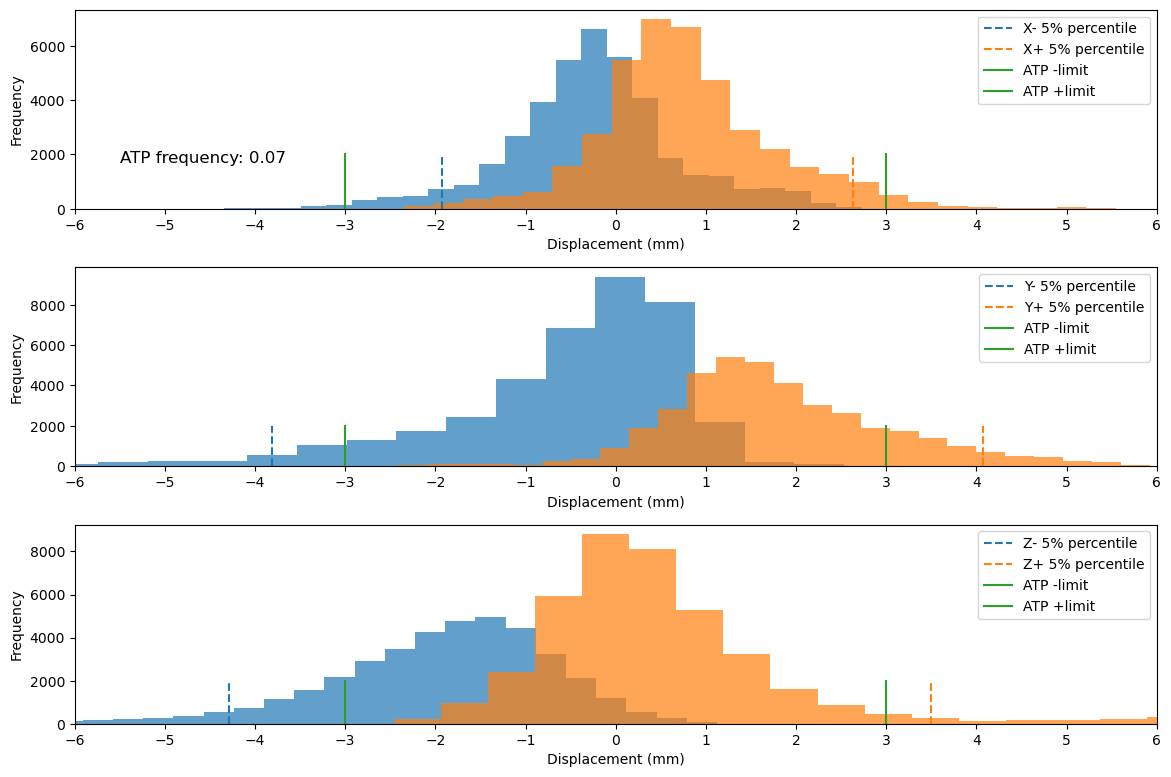

In [96]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30/2.54, 20/2.54))

# KOLLA DETTA
[[txp, txm], [cxp, cxm], [typ, tym], [syp, sym], [szp, szm], [czp, czm]] = displacement_stats

dx_minus = [min(res[0][1], res[1][1]) for res in simulation_results]
dx_plus = [max(res[0][0], res[1][0]) for res in simulation_results]
dy_minus = [min(res[2][1], res[3][1]) for res in simulation_results]
dy_plus = [max(res[2][0], res[3][0]) for res in simulation_results]
dz_minus = [min(res[4][1], res[5][1]) for res in simulation_results]
dz_plus = [max(res[4][0], res[5][0]) for res in simulation_results]


ax1.hist(dx_minus, bins=30, alpha=0.7, color='C0')
ax1.hist(dx_plus, bins=30, alpha=0.7, color='C1')
dxm_percentile = np.percentile(dx_minus, 5)
dxp_percentile = np.percentile(dx_plus, 95)
ax1.plot([dxm_percentile, dxm_percentile], [0, 2000], color='C0', linestyle='--', label='X- 5% percentile')
ax1.plot([dxp_percentile, dxp_percentile], [0, 2000], color='C1', linestyle='--', label='X+ 5% percentile')
ax1.plot([atp_limit[0,0], atp_limit[0,0]], [0, 2000], color='C2', linestyle='-', label='ATP -limit')
ax1.plot([atp_limit[0,1], atp_limit[0,1]], [0, 2000], color='C2', linestyle='-', label='ATP +limit')
ax1.text(-5.5, 1700, f"ATP frequency: {np.mean(atps):.2f}", fontsize=12, ha='left')

ax2.hist(dy_minus, bins=30, alpha=0.7, color='C0')
ax2.hist(dy_plus, bins=30, alpha=0.7, color='C1')
dym_percentile = np.percentile(dy_minus, 5)
dyp_percentile = np.percentile(dy_plus, 95)
ax2.plot([dym_percentile, dym_percentile], [0, 2000], color='C0', linestyle='--', label='Y- 5% percentile')
ax2.plot([dyp_percentile, dyp_percentile], [0, 2000], color='C1', linestyle='--', label='Y+ 5% percentile')
ax2.plot([atp_limit[1,0], atp_limit[1,0]], [0, 2000], color='C2', linestyle='-', label='ATP -limit')
ax2.plot([atp_limit[1,1], atp_limit[1,1]], [0, 2000], color='C2', linestyle='-', label='ATP +limit')

ax3.hist(dz_minus, bins=30, alpha=0.7, color='C0')
ax3.hist(dz_plus, bins=30, alpha=0.7, color='C1')
dzm_percentile = np.percentile(dz_minus, 5)
dzp_percentile = np.percentile(dz_plus, 95)
ax3.plot([dzm_percentile, dzm_percentile], [0, 2000], color='C0', linestyle='--', label='Z- 5% percentile')
ax3.plot([dzp_percentile, dzp_percentile], [0, 2000], color='C1', linestyle='--', label='Z+ 5% percentile')
ax3.plot([atp_limit[2,0], atp_limit[2,0]], [0, 2000], color='C2', linestyle='-', label='ATP -limit')   
ax3.plot([atp_limit[2,1], atp_limit[2,1]], [0, 2000], color='C2', linestyle='-', label='ATP +limit')

for ax in [ax1, ax2, ax3]:
    ax.legend(loc='upper right', fontsize=10)
    ax.set_xlabel('Displacement (mm)')
    ax.set_ylabel('Frequency')
    ax.set_xticks(np.arange(-6, 7, 1))
    ax.set_xlim([-6, 6])

f.tight_layout()

print(f'Mean ATP frequency: {np.mean(atps):.2f}')
print(f'Marginal X {dxm_percentile:.2f}, {dxp_percentile:.2f}')
print(f'Marginal Y {dym_percentile:.2f}, {dyp_percentile:.2f}')
print(f'Marginal Z {dzm_percentile:.2f}, {dzp_percentile:.2f}')